In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataSet/Analysis/dirty_cafe_sales.csv')
df

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
...,...,...,...,...,...,...,...,...
9995,TXN_7672686,Coffee,2,2.0,4.0,NaN,UNKNOWN,2023-08-30
9996,TXN_9659401,NaN,3,NaN,3.0,Digital Wallet,NaN,2023-06-02
9997,TXN_5255387,Coffee,4,2.0,8.0,Digital Wallet,NaN,2023-03-02
9998,TXN_7695629,Cookie,3,NaN,3.0,Digital Wallet,NaN,2023-12-02


# NaN values were detected right away, representing "Not a Number" and indicating empty cells.

# Dataset details can be explored using the describe() and info()

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [4]:
df.describe()


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_9226047,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


# 1- Transaction ID contains no Null, NaN, or empty values.

# 2- Null values are present in Item, Quantity, Price Per Unit, Total Spent, Payment Method, Location, and Transaction Date.

# 3- All columns are currently of type object and require adjustment. Each will be addressed individually.

#**Empty values in the Item column can be resolved by deducing the item based on the Price Per Unit.**


In [5]:
#let's make a price dict
item_price = {
    'Coffee': 2.0,
    'Tea': 1.5,
    'Sandwich': 4.0,
    'Salad': 3.0,
    'Cake': 3.0,
    'Cookie': 1.0,
    'Smoothie': 4.0,
    'Juice': 3.0
}

# Reverse mapping (price to item)
price_item = {price: item for item, price in item_price.items()}

# Fill missing 'Item' values based on 'Price Per Unit'
df['Item'] = df['Item'].fillna(df['Price Per Unit'].map(price_item))

df.describe()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_9226047,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


In [6]:
try:
    df['Price Per Unit']=df['Price Per Unit'].astype(float)
except Exception as e:
    print(e)
    pass

could not convert string to float: 'ERROR'


In [7]:
df['Price Per Unit'] = df['Price Per Unit'].replace(['ERROR', 'UNKNOWN'], np.nan)
df['Price Per Unit']=df['Price Per Unit'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    10000 non-null  object 
 1   Item              9667 non-null   object 
 2   Quantity          9862 non-null   object 
 3   Price Per Unit    9467 non-null   float64
 4   Total Spent       9827 non-null   object 
 5   Payment Method    7421 non-null   object 
 6   Location          6735 non-null   object 
 7   Transaction Date  9841 non-null   object 
dtypes: float64(1), object(7)
memory usage: 625.1+ KB


In [8]:
df['Item'] = df['Item'].fillna(df['Price Per Unit'].map(price_item))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    10000 non-null  object 
 1   Item              9939 non-null   object 
 2   Quantity          9862 non-null   object 
 3   Price Per Unit    9467 non-null   float64
 4   Total Spent       9827 non-null   object 
 5   Payment Method    7421 non-null   object 
 6   Location          6735 non-null   object 
 7   Transaction Date  9841 non-null   object 
dtypes: float64(1), object(7)
memory usage: 625.1+ KB


# Around 61 missing values remain, caused by NaN entries in both 'Price Per Unit' and 'Item'.

In [9]:
df['Total Spent'] = df['Total Spent'].replace(['ERROR', 'UNKNOWN'], np.nan)
df['Total Spent']=df['Total Spent'].astype(float)

#Converting Quantity

In [10]:
df['Quantity'] = df['Quantity'].replace(['ERROR', 'UNKNOWN'], np.nan)
df['Quantity']=df['Quantity'].astype(float)

# Filling the null value in column Price Per Unit


In [11]:
df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Total Spent']/df['Quantity'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    10000 non-null  object 
 1   Item              9939 non-null   object 
 2   Quantity          9521 non-null   float64
 3   Price Per Unit    9962 non-null   float64
 4   Total Spent       9498 non-null   float64
 5   Payment Method    7421 non-null   object 
 6   Location          6735 non-null   object 
 7   Transaction Date  9841 non-null   object 
dtypes: float64(3), object(5)
memory usage: 625.1+ KB


In [12]:
df['Item'] = df['Item'].fillna(df['Price Per Unit'].map(price_item))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    10000 non-null  object 
 1   Item              9960 non-null   object 
 2   Quantity          9521 non-null   float64
 3   Price Per Unit    9962 non-null   float64
 4   Total Spent       9498 non-null   float64
 5   Payment Method    7421 non-null   object 
 6   Location          6735 non-null   object 
 7   Transaction Date  9841 non-null   object 
dtypes: float64(3), object(5)
memory usage: 625.1+ KB


# Missing items remain, and since they cannot be determined, they will be dropped.



In [13]:
df.dropna(subset=['Item'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9960 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    9960 non-null   object 
 1   Item              9960 non-null   object 
 2   Quantity          9484 non-null   float64
 3   Price Per Unit    9924 non-null   float64
 4   Total Spent       9460 non-null   float64
 5   Payment Method    7391 non-null   object 
 6   Location          6712 non-null   object 
 7   Transaction Date  9801 non-null   object 
dtypes: float64(3), object(5)
memory usage: 700.3+ KB


# The 'Transaction Date' column is crucial, and because missing dates cannot be recovered, null entries are removed.

In [14]:
df.dropna(subset=['Transaction Date'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9801 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    9801 non-null   object 
 1   Item              9801 non-null   object 
 2   Quantity          9334 non-null   float64
 3   Price Per Unit    9767 non-null   float64
 4   Total Spent       9310 non-null   float64
 5   Payment Method    7280 non-null   object 
 6   Location          6607 non-null   object 
 7   Transaction Date  9801 non-null   object 
dtypes: float64(3), object(5)
memory usage: 689.1+ KB


# Some missing values remain in the 'Price Per Unit' column. The same approach applied to the 'Item' column can be used here, but this time with the item_price dictionary.

In [15]:
df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Item'].map(item_price))
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9801 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    9801 non-null   object 
 1   Item              9801 non-null   object 
 2   Quantity          9334 non-null   float64
 3   Price Per Unit    9797 non-null   float64
 4   Total Spent       9310 non-null   float64
 5   Payment Method    7280 non-null   object 
 6   Location          6607 non-null   object 
 7   Transaction Date  9801 non-null   object 
dtypes: float64(3), object(5)
memory usage: 689.1+ KB


# Items labeled as UNKNOWN or ERROR will be dropped.

In [16]:
df = df[~df['Item'].isin(['ERROR', 'UNKNOWN'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9175 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    9175 non-null   object 
 1   Item              9175 non-null   object 
 2   Quantity          8749 non-null   float64
 3   Price Per Unit    9175 non-null   float64
 4   Total Spent       8723 non-null   float64
 5   Payment Method    6819 non-null   object 
 6   Location          6192 non-null   object 
 7   Transaction Date  9175 non-null   object 
dtypes: float64(3), object(5)
memory usage: 645.1+ KB


# The remaining columns with null values are:
# Quantity
# Total Spent

# Payment Method

# Location

# **Total Spent** = Quantity × Price Per Unit

In [17]:
df.loc[df['Total Spent'].isna(), 'Total Spent'] = df['Quantity'] * df['Price Per Unit']


In [18]:
df.isna().sum()


,0
Transaction ID,0
Item,0
Quantity,426
Price Per Unit,0
Total Spent,20
Payment Method,2356
Location,2983
Transaction Date,0


In [19]:
#dropping null values i Total Spent as it is less data
df.dropna(subset  = 'Total Spent', inplace = True)

/tmp/ipython-input-508324142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset  = 'Total Spent', inplace = True)


In [20]:
df.isna().sum()


,0
Transaction ID,0
Item,0
Quantity,406
Price Per Unit,0
Total Spent,0
Payment Method,2349
Location,2978
Transaction Date,0


# **Quantity** = Total Spent / Price Per Unit

In [21]:
df['Quantity']= df['Quantity'].fillna(df['Total Spent']/df['Price Per Unit'])


/tmp/ipython-input-1931374357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quantity']= df['Quantity'].fillna(df['Total Spent']/df['Price Per Unit'])


In [22]:
df.isna().sum()


,0
Transaction ID,0
Item,0
Quantity,0
Price Per Unit,0
Total Spent,0
Payment Method,2349
Location,2978
Transaction Date,0


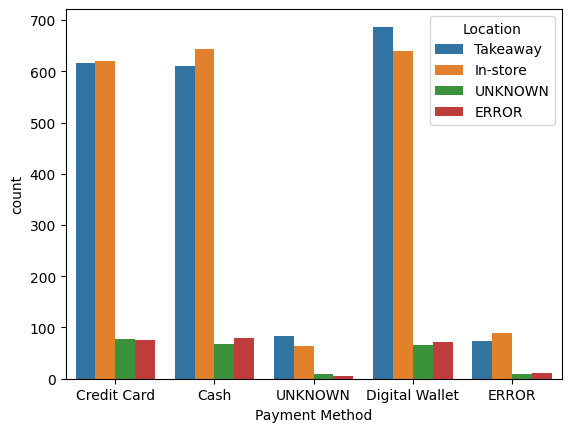

In [23]:
sns.countplot(x = 'Payment Method', hue = 'Location', data = df)
plt.show()

In [24]:
# Replace UNKNOWN and ERROR with NaN in Location
df.loc[df['Location'].isin(['UNKNOWN', 'ERROR']), 'Location'] = np.nan

# Fill missing Location with In-store if Payment Method is Cash
df.loc[(df['Payment Method'] == 'Cash') & (df['Location'].isna()), 'Location'] = 'In-store'

# Fill missing Location with In-store if Payment Method is Credit Card
df.loc[(df['Payment Method'] == 'Credit Card') & (df['Location'].isna()), 'Location'] = 'In-store'

# Fill missing Location with Takeaway if Payment Method is Digital Wallet
df.loc[(df['Payment Method'] == 'Digital Wallet') & (df['Location'].isna()), 'Location'] = 'Takeaway'


In [25]:
df.isna().sum()


,0
Transaction ID,0
Item,0
Quantity,0
Price Per Unit,0
Total Spent,0
Payment Method,2349
Location,1181
Transaction Date,0


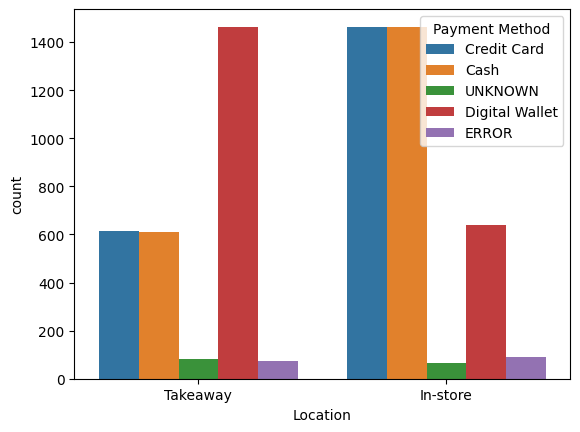

In [26]:
sns.countplot(x = 'Location', hue = 'Payment Method', data = df)
plt.show()

In [27]:
# Replace UNKNOWN and ERROR with NaN in Payment Method
df.loc[df['Payment Method'].isin(['UNKNOWN', 'ERROR']), 'Payment Method'] = np.nan

# Fill missing Payment Method with Digital Wallet if Location is Takeaway
df.loc[(df['Location'] == 'Takeaway') & (df['Payment Method'].isna()), 'Payment Method'] = 'Digital Wallet'

# Fill missing Payment Method with Cash if Location is In-store
df.loc[(df['Location'] == 'In-store') & (df['Payment Method'].isna()), 'Payment Method'] = 'Cash'


In [28]:
df.isna().sum()


,0
Transaction ID,0
Item,0
Quantity,0
Price Per Unit,0
Total Spent,0
Payment Method,1181
Location,1181
Transaction Date,0


In [29]:
df.dropna(subset = ['Location', 'Payment Method'], inplace = True)


/tmp/ipython-input-3418302568.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset = ['Location', 'Payment Method'], inplace = True)


In [30]:
df.isna().sum()


,0
Transaction ID,0
Item,0
Quantity,0
Price Per Unit,0
Total Spent,0
Payment Method,0
Location,0
Transaction Date,0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7974 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    7974 non-null   object 
 1   Item              7974 non-null   object 
 2   Quantity          7974 non-null   float64
 3   Price Per Unit    7974 non-null   float64
 4   Total Spent       7974 non-null   float64
 5   Payment Method    7974 non-null   object 
 6   Location          7974 non-null   object 
 7   Transaction Date  7974 non-null   object 
dtypes: float64(3), object(5)
memory usage: 560.7+ KB


In [32]:
df.shape


(7974, 8)

In [33]:
# 1. Save the cleaned DataFrame to a new CSV file
# (Make sure your clean DataFrame variable is named df)
df.to_csv('cleaned_cafe_sales.csv', index=False, encoding='utf-8')

from google.colab import files

# 2. Download the newly created file using its new name
files.download('cleaned_cafe_sales.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ***Machine Learning***

In [34]:
data = df
data

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,TXN_2602893,Smoothie,5.0,4.0,20.0,Credit Card,In-store,2023-03-31
...,...,...,...,...,...,...,...,...
9993,TXN_4766549,Smoothie,2.0,4.0,8.0,Cash,In-store,2023-10-20
9996,TXN_9659401,Cookie,3.0,1.0,3.0,Digital Wallet,Takeaway,2023-06-02
9997,TXN_5255387,Coffee,4.0,2.0,8.0,Digital Wallet,Takeaway,2023-03-02
9998,TXN_7695629,Cookie,3.0,1.0,3.0,Digital Wallet,Takeaway,2023-12-02


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7974 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    7974 non-null   object 
 1   Item              7974 non-null   object 
 2   Quantity          7974 non-null   float64
 3   Price Per Unit    7974 non-null   float64
 4   Total Spent       7974 non-null   float64
 5   Payment Method    7974 non-null   object 
 6   Location          7974 non-null   object 
 7   Transaction Date  7974 non-null   object 
dtypes: float64(3), object(5)
memory usage: 560.7+ KB


# Removing variables that will not be used in model training


In [36]:
data = data.drop(columns=['Transaction ID','Transaction Date'])

In [37]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

label_mappings = {}

for col in data.select_dtypes('object'):
    data[col] = encoder.fit_transform(data[col])
    label_mappings[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

for col, mapping in label_mappings.items():
    print(f"Column: {col}")
    for label, code in mapping.items():
        print(f"{code} -> {label}")
    print()


Column: Item
0 -> Cake
1 -> Coffee
2 -> Cookie
3 -> Juice
4 -> Salad
5 -> Sandwich
6 -> Smoothie
7 -> Tea

Column: Payment Method
0 -> Cash
1 -> Credit Card
2 -> Digital Wallet

Column: Location
0 -> In-store
1 -> Takeaway



In [38]:
data

,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location
0,1,2.0,2.0,4.0,1,1
1,0,4.0,3.0,12.0,0,0
2,2,4.0,1.0,4.0,1,0
4,1,2.0,2.0,4.0,2,0
5,6,5.0,4.0,20.0,1,0
...,...,...,...,...,...,...
9993,6,2.0,4.0,8.0,0,0
9996,2,3.0,1.0,3.0,2,1
9997,1,4.0,2.0,8.0,2,1
9998,2,3.0,1.0,3.0,2,1


In [39]:
from sklearn.model_selection import train_test_split

X = data.drop('Total Spent',axis = 1)
y = data['Total Spent']


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)

(6379, 5) (1595, 5)


# KNN

In [41]:
knn = KNeighborsRegressor()
knn_model = knn.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [42]:
knn_mse = mean_squared_error(y_test, y_pred)
knn_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {knn_mse}")
print(f"R2 Score: {knn_r2}")

Mean Squared Error: 0.0
R2 Score: 1.0


# Linear Regression


In [44]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [45]:
lr_mse = mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {lr_mse}")
print(f"R2 Score: {lr_r2}")

Mean Squared Error: 3.662787082954171
R2 Score: 0.9027125522071031


# XGBoost

In [46]:
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train),
y_pred = xgb_model.predict(X_test)

In [47]:
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {xgb_mse}")
print(f"R2 Score: {xgb_r2}")

Mean Squared Error: 0.06269432290008131
R2 Score: 0.998334773349388


# All Results


In [48]:
models = ['KNN', 'XGBoost','Linear Regression']
mse_scores = [knn_mse, xgb_mse, lr_mse]
r2_scores = [knn_r2, xgb_r2, lr_r2]

mse_values = [f'{score:.4f}' for score in mse_scores]
r2_values = [f'{score:.4f}' for score in r2_scores]

results_data = pd.DataFrame({
    'Model': models,
    'MSE': mse_values,
    'R^2': r2_values
})
print(results_data)

               Model     MSE     R^2
0                KNN  0.0000  1.0000
1            XGBoost  0.0627  0.9983
2  Linear Regression  3.6628  0.9027
